<a href="https://colab.research.google.com/github/charlaburnett/dc_heat_analysis/blob/main/dc_heat_osint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Geotag News Lookup

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [16]:
from gnews import GNews
gnews = GNews()
gnews.language = 'en'
gnews.country = 'US'
gnews.max_results = 100

query = '"heat wave" OR "heat record" "Washington DC" OR "District of Columbia"'
news_data = gnews.get_news(query)


In [17]:
def is_about_dc(article):
    dc_keywords = ["Washington, DC", "Washington DC", "District of Columbia", "D.C.", "the nation's capital"]
    text = (article.get("title", "") + article.get("description", "")).lower()
    return any(k.lower() in text for k in dc_keywords)

dc_articles = [a for a in news_data if is_about_dc(a)]


In [18]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="dc_heat_geo")

coords = geolocator.geocode("Washington, DC")
latlon = (coords.latitude, coords.longitude)

# Enrich each article with lat/lon
for article in news_data:
    article["latitude"] = latlon[0]
    article["longitude"] = latlon[1]


In [19]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="heat_dc_scraper")

coords = geolocator.geocode("Washington, DC")
latlon = (coords.latitude, coords.longitude)

for article in dc_articles:
    title = article.get("title", "N/A")
    pub_date = article.get("published date", "N/A")
    url = article.get("url", "N/A")

    print(f"{title}")
    print(f"{pub_date}")
    print(f"{latlon}")
    print(f"{url}\n")


D.C. faces brutal heat and humidity next week. Here’s how hot it could get. - The Washington Post
Fri, 20 Jun 2025 07:00:00 GMT
(38.8950368, -77.0365427)
https://news.google.com/rss/articles/CBMifEFVX3lxTFBfbmVqYkdZQWRqOUw2T1VfWWd1dFFVZUNFR3V5VUxLQ1RpMjhzVDRkVUpxOUY3Tl9hZVh6cGw1S0F1RWgwY2p4b0tRWjZGZkZJTGxzaVZnc3BTS2NFMVY0dFhXS0M4aW1EU2RPLTd1OXdMWE1ENVNMMUNUUUg?oc=5&hl=en-US&gl=US&ceid=US:en

D.C. sees another heat wave amid a drought watch - Axios
Wed, 31 Jul 2024 07:00:00 GMT
(38.8950368, -77.0365427)
https://news.google.com/rss/articles/CBMiekFVX3lxTE9LLURha20teTN0TVlWYXdqY1U4RWhFSEdXVGpGRkNzZlBIU1NSMmxmNVdHUVdqTXA2MEdwN1QzdDNXdlBNdnFtRnc0TVhISmJSalVnV0NiNklfU1dGZVBpNGRPclpqVUR0aUdibG1aOU41RGZUTFMtVEFB?oc=5&hl=en-US&gl=US&ceid=US:en

Washington, D.C., Endures Most Blistering Heat Wave in Nearly 100 Years - Newsweek
Wed, 17 Jul 2024 07:00:00 GMT
(38.8950368, -77.0365427)
https://news.google.com/rss/articles/CBMijAFBVV95cUxOd0V1dDF3YmdWbFRJc3NBckVWUC1iX09OUnB1MkxwRk1CTzJsMFpGOEFFZjZyMk

In [33]:
import import_ipynb
import sys

sys.path.append('/content/drive/MyDrive/Colab Notebooks')

In [34]:
prompt = """You are an OSINT analyst reviewing reported heat wave events for the city of Washington, District of Columbia.
The following headlines may relate to heat waves and erratic climate events.

Your task is to:
1. Identify trends related to heat waves, heat spots, and erratic climate events over the years,
2. Group them by date,
3. Indicate confidence level if details are unclear,
4. Suggest whether any might explain observed heat increases.

Headlines:\n\n"""

for article in news_data:
    title = article.get("title", "")
    date = article.get("published date", "")[:10]
    prompt += f"- ({date}) {title}\n"


In [44]:
import geopandas as gpd

gdf = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/dc-urban-heat/uhi_temp_change_2015_2025_fahrenheit.shp")

summary = gdf[["temp_chang", "geometry"]].sort_values("temp_chang", ascending=False).head(10)

heat_summary = "Temperature Change Summary (Top 10):\n"
for i, row in summary.iterrows():
    heat_summary += f"- Area {i + 1}: {round(row['temp_chang'], 2)}°F increase\n"


In [48]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
# openai_key.py should contain:
# import openai
# openai.api_key = "sk-..."

# gnews_key.py should contain:
# GNEWS_API_KEY = "your-gnews-api-key"

from openai_key import openai
from gnews_key import GNEWS_API_KEY
from openai import OpenAI



In [64]:
from openai_key import openai
from openai import OpenAI
import pandas as pd

client = OpenAI(api_key=openai.api_key)

# Step 1: Build base OSINT analyst prompt
prompt = """You are an OSINT analyst reviewing reported heat wave events for the city of Washington, District of Columbia.

Your task is to:
1. Identify trends related to heat waves, heat spots, and erratic climate events over the years,
2. Group them by date,
3. Indicate confidence level if details are unclear,
4. Suggest whether any might explain observed heat increases.

Headlines:\n\n"""

# Step 2: Append headlines from scraped news
for article in news_data:
    title = article.get("title", "")
    date = article.get("published date", "")[:10]
    prompt += f"- ({date}) {title}\n"

# Step 3: Append Urban Heat Island data summary
prompt += "\nUrban Heat Island Temperature Change Summary (Top 10 Areas):\n"
for i, row in summary.iterrows():
    prompt += f"- Area {i + 1}: {round(row['temp_chang'], 2)}°F increase\n"

# Step 4: Final analytical instruction
prompt += """

Based on the above news reports and heat data, analyze whether the headlines explain the spatial patterns of heat increase.
Call out any temporal or geographic trends, inconsistencies, or missing coverage in the media.
Provide insights useful for urban resilience planning.
"""

# Step 5: Call OpenAI with new client syntax
response = client.chat.completions.create(
    model="gpt-4",
    messages=[
        {
            "role": "system",
            "content": "You are an OSINT analyst focused on urban climate resilience."
        },
        {
            "role": "user",
            "content": prompt
        }
    ]
)

# Step 6: Output
print(response.choices[0].message.content)


Review of news headlines:
The reported heat wave events predominantly occurred in the months of June (Ju) and July (Ju), supporting the normal seasonal pattern of summer heat waves. There were however some outliers with heatwaves reported in September (Se), August (Au), and even fall month of October (Oc). Headlines from a broad range of major news sources report an escalating pattern of severe heat waves during these months in Washington, D.C., characterized by extreme heat, humidity, and record-shattering temperatures. References to the heat wave being the "first", "most blistering", "shattering record", and "hottest day in over a decade" suggest an unprecedented surge in intensity over time.

Based on headlines, there seems to be repeated heatwaves throughout the reported period, with wording hinting at severe heat conditions becoming the norm rather than an exception. Several headlines indicate that the city implemented emergency measures such as closure of the Washington Monument,

In [84]:
from census import Census
import geopandas as gpd
import pandas as pd
import cenpy
import os


c = Census(os.environ["CENSUS_API_KEY"])

In [87]:
# B19013_001E = Median Household Income
dc_income_data = c.acs5.state_county_tract(
    fields=["B19013_001E"],
    state_fips="11",      # Washington DC
    county_fips="001",
    tract="*",
    year=2021
)

income_df = pd.DataFrame(dc_income_data)
income_df.rename(columns={"B19013_001E": "median_income"}, inplace=True)

income_df["GEOID"] = income_df["state"] + income_df["county"] + income_df["tract"]
income_df = income_df[["GEOID", "median_income"]].astype({"median_income": "float"})

income_df.head()


,GEOID,median_income
0,11001000101,157276.0
1,11001000102,166816.0
2,11001000201,-666666666.0
3,11001000202,161490.0
4,11001000300,159714.0


In [92]:
!rm -rf dc_tracts dc_tracts.zip

!wget -q https://www2.census.gov/geo/tiger/TIGER2021/TRACT/tl_2021_11_tract.zip -O dc_tracts.zip

!unzip -q dc_tracts.zip -d dc_tracts

!ls dc_tracts


tl_2021_11_tract.cpg  tl_2021_11_tract.shp	       tl_2021_11_tract.shx
tl_2021_11_tract.dbf  tl_2021_11_tract.shp.ea.iso.xml
tl_2021_11_tract.prj  tl_2021_11_tract.shp.iso.xml


In [93]:
import geopandas as gpd

tracts = gpd.read_file("dc_tracts/tl_2021_11_tract.shp")
tracts = tracts.to_crs("EPSG:4326")
tracts = tracts[["GEOID", "geometry"]]


In [94]:
gdf = gdf.to_crs(tracts.crs)

gdf_with_geoids = gpd.sjoin(gdf, tracts, how="left", predicate="intersects")


In [95]:
merged = gdf_with_geoids.merge(income_df, on="GEOID")

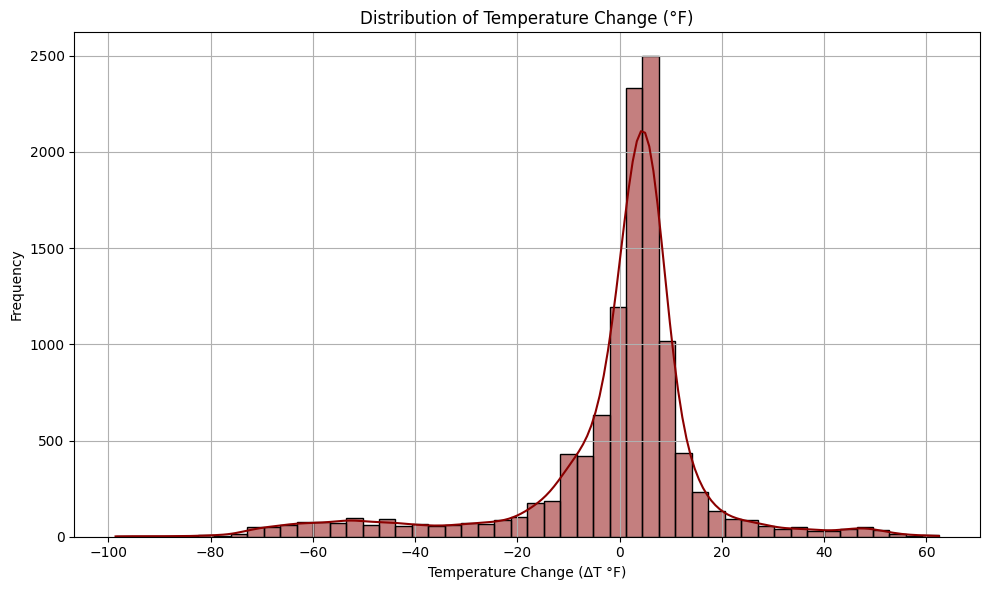

                    Robust linear Model Regression Results                    
Dep. Variable:             temp_chang   No. Observations:                11125
Model:                            RLM   Df Residuals:                    11123
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 20 Jul 2025                                         
Time:                        04:01:55                                         
No. Iterations:                    24                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.8163      0.081     34.922

In [112]:
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
import numpy as np

# Step 1: Drop NA values and inspect distribution
reg_df = merged.dropna(subset=["temp_chang", "median_income"]).copy()

# Step 2: Plot histogram to visualize skewness and distribution
plt.figure(figsize=(10, 6))
sns.histplot(reg_df["temp_chang"], kde=True, bins=50, color="darkred")
plt.title("Distribution of Temperature Change (°F)")
plt.xlabel("Temperature Change (ΔT °F)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 3: Remove extreme outliers (z-score outside ±3)
reg_df["z_temp"] = zscore(reg_df["temp_chang"])
reg_df = reg_df[(reg_df["z_temp"] > -3) & (reg_df["z_temp"] < 3)]

# Step 4: Define independent and dependent variables
X = sm.add_constant(reg_df[["median_income"]])  # Add intercept
y = reg_df["temp_chang"]

# Step 5: Fit robust regression model (HuberT handles mild outliers)
robust_model = sm.RLM(y, X, M=sm.robust.norms.HuberT()).fit()

# Step 6: Output summary
print(robust_model.summary())


In [113]:
import io

regression_output = io.StringIO()
print(model.summary(), file=regression_output)
regression_text = regression_output.getvalue()



In [114]:
prompt += """

The following regression analysis examines whether household income correlates with heat increase:

Regression Summary:
--------------------
""" + regression_text + """

Please interpret the regression. Specifically:
- Is income statistically significantly associated with heat increase?
- What does the coefficient direction and magnitude suggest?
- Why might R-squared be low?
- Do results support the hypothesis that low-income areas experience more heat gain?
- Suggest follow-up statistical or spatial analyses that could improve insight.
"""


In [115]:
response = client.chat.completions.create(
    model="gpt-4",
    messages=[
        {
            "role": "system",
            "content": "You are an OSINT analyst focused on urban climate resilience."
        },
        {
            "role": "user",
            "content": prompt
        }
    ]
)

print(response.choices[0].message.content)


1. Analysis of Heat Wave Events:

On the analysis of the reported heat events, an obviously alarming trend is apparent in Washington D.C and its suburbs. There have been frequent mentions of heat waves and extreme heat events in July with the heat index reaching up to 110 degrees. A significant trend in these events is that heat wave conditions have started in mid-July and peaked during the last week of the same month, with many reports of consecutive days of record-breaking temperatures. 

The heatwaves appear to be lasting longer and reaching higher peak temperatures as well, with several reports in late July of the worst heatwaves in almost a decade. This consistent heatwave falls into the climate prediction models that anticipate increased frequency and intensity of heatwaves due to global warming. Additionally, noting that these events seem to be more pronounced and frequent with each successive onset of summer indicates that the occurrences are not only seasonal but also might be

In [102]:
gdf["temp_chang"].max()


63.517730712890625

In [104]:
import geopandas as gpd

comparison_f = gpd.read_file(
    "/content/drive/MyDrive/Colab Notebooks/dc-urban-heat/uhi_temp_change_2015_2025_fahrenheit.shp"
)


In [107]:
from scipy import stats
import numpy as np

# Extract and clean temperature change data
temp_deltas = comparison_f["temp_chang"].dropna()

# Calculate z-scores
z_scores = stats.zscore(temp_deltas)

# Define threshold (commonly 3 standard deviations)
threshold = 3

# Get outlier indices
outlier_indices = np.where(np.abs(z_scores) > threshold)[0]

# Display outliers
outliers = temp_deltas.iloc[outlier_indices]
print(f"Number of outliers: {len(outliers)}")
print(outliers)


Number of outliers: 886
5047    -45.005108
5080    -45.381580
5119    -44.334450
5191    -44.488257
5381    -46.337067
           ...    
30406    56.793106
30617    57.154883
30673    56.542646
30729    55.522655
30780    53.378529
Name: temp_chang, Length: 886, dtype: float64
